<a href="https://colab.research.google.com/github/rtheman/CLV/blob/master/2_Code/CLV__UK_online_retailer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Data**: https://www.kaggle.com/roshansharma/online-retail?select=online+retail.csv

NOTE:
1. `InvoiceNo` is alphanumeric
1. `InvoiceDate` in formatted as dd.mm/yy h.mm

**Reference**
- Peter Fader [video](https://www.youtube.com/watch?v=guj2gVEEx4s)

**Examples**
- Collin Ching's [Medium blog](https://towardsdatascience.com/modeling-customer-churn-for-an-e-commerce-business-with-python-874315e688bf)
- Luca De Angelis [Medium blog](https://towardsdatascience.com/predicting-customer-lifetime-value-with-buy-til-you-die-probabilistic-models-in-python-f5cac78758d9)
- Gamma-Gamma [example01](https://books.google.com/books?id=_xamDwAAQBAJ&pg=PA99&lpg=PA99&dq=GammaGammaFitter&source=bl&ots=s-SdLrKpZP&sig=ACfU3U2ChOfkDkgzfGdu_6PhAizXg-T80Q&hl=en&sa=X&ved=2ahUKEwje3IaBud_pAhX7HzQIHaqpCUgQ6AEwBXoECAoQAQ#v=onepage&q=GammaGammaFitter&f=false)
- Gamma-Gamma [example02](https://www.mikulskibartosz.name/predicting-customer-lifetime-value-using-the-pareto-nbd-model-and-gamma-gamma-model/) by Bartosz Mikulski

# 1.) Connect to Google BigQuery

See [BigQuery documentation](https://cloud.google.com/bigquery/docs) and [library reference documentation](https://googleapis.dev/python/bigquery/latest/index.html#).

Example. https://colab.research.google.com/notebooks/bigquery.ipynb#scrollTo=ONI1Xo0-KtAD

## Set Credentials

In [1]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


## Enable data table display
Colab includes the google.colab.data_table package that can be used to display large pandas dataframes as an interactive data table. It can be enabled with:

In [0]:
%load_ext google.colab.data_table

To disable, simply
`%unload_ext google.colab.data_table`

## Set BigQuery's Project ID

In [0]:
# Declare the Cloud project ID which will be used throughout this notebook
project_id = 'rleung-sandbox'

# 2.) Query

## Initiaize BigQuery parameters

In [0]:
from google.cloud import bigquery

client = bigquery.Client(project=project_id)

## Count number of records in table

In [4]:
row_count = client.query('''
  SELECT 
    COUNT(*) as total
  FROM `rleung-sandbox.CLV.online_retailer_UK`''').to_dataframe().total[0]

print('Full dataset has %d rows' % row_count)

Full dataset has 532619 rows


Count number of Customers

In [16]:
cust_count = client.query('''
                          SELECT
                            COUNT(DISTINCT CustomerID) as total
                          FROM `rleung-sandbox.CLV.online_retailer_UK`
                          ''').to_dataframe().total[0]

print('There are %d customers' % cust_count)

There are 4339 customers


## Persist as dataframe

In [0]:
df = client.query('''
  SELECT
    *
  FROM
    `rleung-sandbox.CLV.online_retailer_UK`
#   LIMIT 100
''').to_dataframe()

In [6]:
df.head()

,CustomerID,InvoiceNo,StockCode,Description,InvoiceDate,Quantity,UnitPrice,Country
0,12646,572215,23293,SET OF 12 FAIRY CAKE BAKING CASES,2011-10-21,32,0.83,USA
1,12646,572215,23296,SET OF 6 TEA TIME BAKING CASES,2011-10-21,32,1.25,USA
2,12646,580553,23366,SET 12 COLOURING PENCILS DOILY,2011-12-05,72,0.65,USA
3,12646,580553,20975,12 PENCILS SMALL TUBE RED RETROSPOT,2011-12-05,72,0.65,USA
4,14911,536540,22355,CHARLOTTE BAG SUKI DESIGN,2010-12-01,50,0.85,EIRE


In [7]:
# Revert to displaying in Pandas format
%unload_ext google.colab.data_table

df.describe()

,Quantity,UnitPrice
count,532619.000000,532619.000000
mean,10.240010,3.847635
std,159.573967,41.758101
min,-9600.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,13541.330000


# 3.) Transform Data as RFM

In [8]:
pip install lifetimes

In [12]:
from lifetimes.utils import summary_data_from_transaction_data

xaction_RFM = summary_data_from_transaction_data(
    df,
    'CustomerID', 
    'InvoiceDate', 
    observation_period_end='2011-12-10'
)

xaction_RFM.head()

,frequency,recency,T
CustomerID,,,
12346,0.0,0.0,326.0
12347,6.0,365.0,368.0
12348,3.0,283.0,359.0
12349,0.0,0.0,19.0
12350,0.0,0.0,311.0


In [13]:
xaction_RFM.describe()

,frequency,recency,T
count,4339.000000,4339.000000,4339.000000
mean,2.864024,130.741415,223.782899
std,5.952745,132.210176,117.883623
min,0.000000,0.000000,1.000000
25%,0.000000,0.000000,113.000000
50%,1.000000,93.000000,249.000000
75%,3.000000,252.000000,327.000000
max,131.000000,373.000000,374.000000


## Customers Distribution by Frequency

This illustrates how often customer buys stuff from us.

TO DO

# 4.) Modeling - BG/NBD model

## Fitting a model

In [17]:
from lifetimes import BetaGeoFitter

bgf = BetaGeoFitter(penalizer_coef = 0.0)
bgf.fit(xaction_RFM['frequency'], xaction_RFM['recency'], xaction_RFM['T'])

<lifetimes.BetaGeoFitter: fitted with 4339 subjects, a: 0.00, alpha: 69.22, b: 6.66, r: 0.83>

In [20]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.825547,0.026745,0.773126,0.877968
alpha,69.216946,2.621429,64.078946,74.354946
a,0.003928,0.010784,-0.017209,0.025065
b,6.657330,20.824086,-34.157879,47.472538


## Analyze Model

### Assess Model's Fit

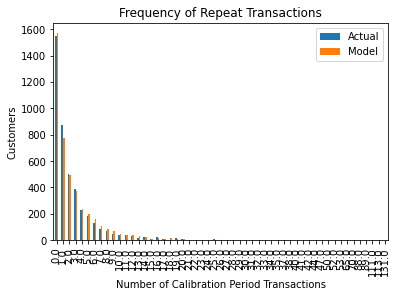

In [29]:
from lifetimes.plotting import plot_period_transactions

plot_period_transactions(bgf, max_frequency=150)

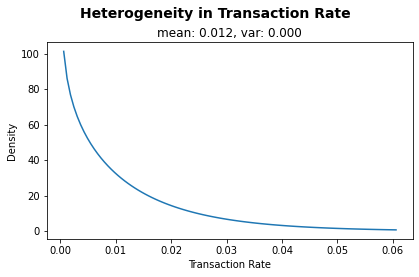

In [25]:
from lifetimes.plotting import plot_transaction_rate_heterogeneity

plot_transaction_rate_heterogeneity(bgf)

### Recency-Frequency Plot

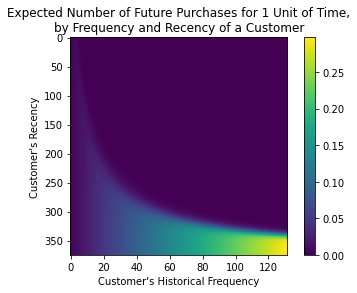

In [21]:
from lifetimes.plotting import plot_frequency_recency_matrix

plot_frequency_recency_matrix(bgf)

### 'Still Alive?' plot

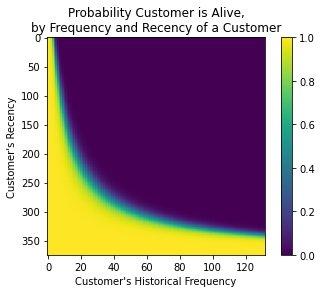

In [22]:
from lifetimes.plotting import plot_probability_alive_matrix

plot_probability_alive_matrix(bgf)

### Rank customer from Best to Worst

Model expose a method that predicts a customer's expected purchases in the next period.

In [24]:
t = 1
xaction_RFM['predicted_purchase'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    t,
    xaction_RFM['frequency'], 
    xaction_RFM['recency'], 
    xaction_RFM['T']
)
xaction_RFM.sort_values(by='predicted_purchase').tail(11)

,frequency,recency,T,predicted_purchase
CustomerID,,,,
14646,44.0,353.0,355.0,0.105656
16422,47.0,352.0,370.0,0.108828
13798,52.0,371.0,373.0,0.119445
14527,53.0,367.0,370.0,0.122537
13089,65.0,367.0,370.0,0.149857
12971,70.0,369.0,373.0,0.160144
14606,88.0,372.0,374.0,0.200398
15311,89.0,373.0,374.0,0.202656
17841,111.0,372.0,374.0,0.252289
